<a href="https://colab.research.google.com/github/Chrisaranguren/Petrophysical_Interpretation_Random_Forest_Regression-/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Packages import
---

In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
import statsmodels.api         as sm
from scipy import stats
import scipy

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor

import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display

# plt.style.use('seaborn')
sns.set_style("whitegrid")

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import sys

# Checking current machine's Python version
sys.version 


'3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]'

## Connection to Drive Folder
---

In order to run this connection successfully you need to follow these steps:

1. Go to your "Shared with me" folder.

2. Right click our "GtX Team" folder and select "Add shortcut to Drive"

3. Run the cell below, go to the shown URL, Allow when asked. Copy the code, paste it on the box, press Enter.

At this point the Notebook will be linked (or "mounted") with your personal Google Drive.

You can check that by clicking on the fourth button of the left panel (that one with the Folder shape).

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Checking the current folder, that Collab is pointing to.

In [4]:
%ls

drive/  sample_data/


Pointing to our data folder

In [5]:
%cd drive/MyDrive/GtX\ Team

/content/drive/.shortcut-targets-by-id/1gwKs1OVax8iNzAyTxKKy3X-dRbN0rr8o/GtX Team


In [6]:
%ls

 data/                      Duvernay/         set_assign.csv
'Data Guide.pdf'            Eaglebine/        StructuredData/
'Dataset dictionary.xlsx'   EDA.ipynb         well_log_files.zip
 Data_static_logs.csv       predictions.csv
 Data_wrangling_GtX.ipynb   predictions.zip


In [7]:
# set paths of different subdirectories
dir_eaglebine = './Eaglebine/'
dir_duvernay = './Duvernay/'

current_file_path = os.path.abspath(os.path.dirname(__name__))
# path to our data directory
data_path = os.path.join(current_file_path, "data")
print(data_path)

/content/drive/.shortcut-targets-by-id/1gwKs1OVax8iNzAyTxKKy3X-dRbN0rr8o/GtX Team/data


# 2. Exploratory Data Analysis
---


In [8]:
train_df = pd.read_csv(os.path.join(data_path,'training.csv'))
val_df = pd.read_csv(os.path.join(data_path,'val_data_no_label.csv'))
logData_df = pd.read_csv(os.path.join(data_path,'LogData.csv')).drop(['Unnamed: 0','Unnamed: 1'],axis=1)

In [9]:
train_df.groupby('Basin')['UWI'].count()

Basin
DV    372
EB    243
Name: UWI, dtype: int64

In [10]:
val_df.groupby('Basin')['UWI'].count()

Basin
DV    127
EB     79
Name: UWI, dtype: int64

In [11]:
train_df.shape, val_df.shape

((615, 331), (206, 331))

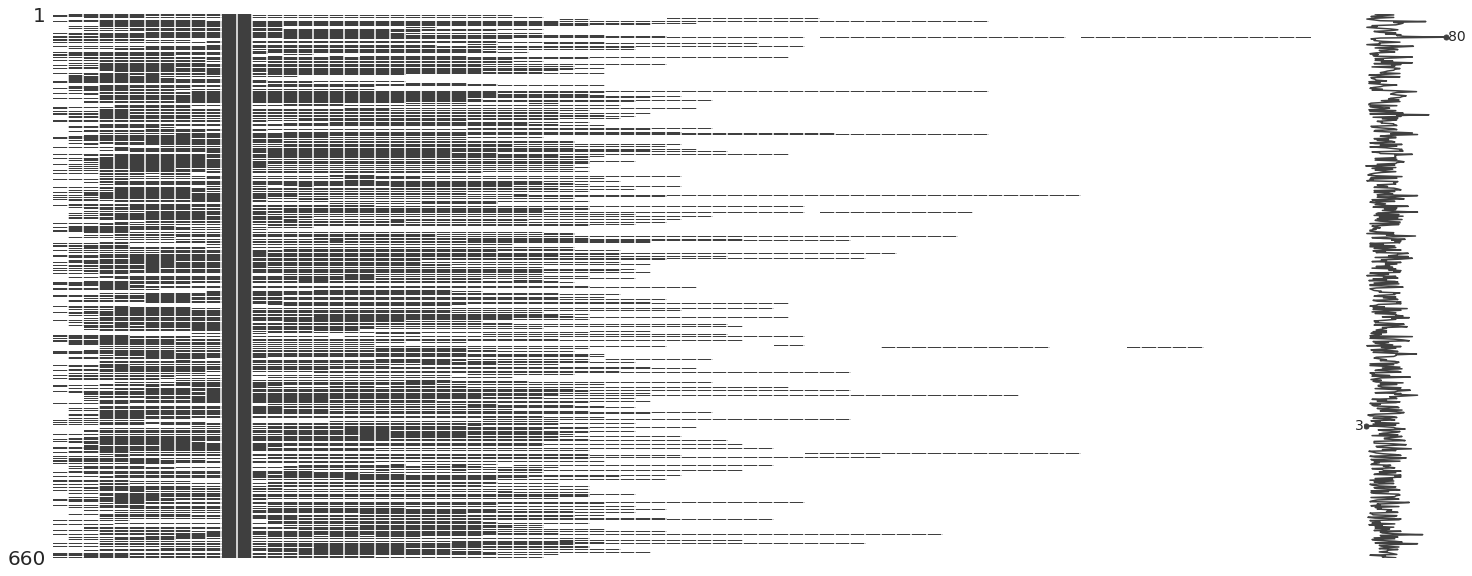

In [12]:
msno.matrix(logData_df)

In [13]:
train_df.head()

,Unnamed: 0_x,UWI,BHT,TrueTemp,Depth_SS(m),Field,TD (ft),Well_Id,Basin,TD_0,TD_1,TD_2,TD_3,TD_4,TD_5,TD_6,TD_7,TD_8,TD_9,TD_10,TD_11,TD_12,KB_0,KB_1,KB_2,KB_3,KB_4,KB_5,KB_6,KB_7,KB_8,KB_9,KB_10,KB_11,KB_12,Mud Wt_0,Mud Wt_1,Mud Wt_2,Mud Wt_3,Mud Wt_4,...,12600.0_GRWS,12900.0_GRWS,13200.0_GRWS,13500.0_GRWS,13800.0_GRWS,14100.0_GRWS,14400.0_GRWS,14700.0_GRWS,15000.0_GRWS,15300.0_GRWS,15600.0_GRWS,15900.0_GRWS,16200.0_GRWS,16500.0_GRWS,16800.0_GRWS,17100.0_GRWS,17400.0_GRWS,17700.0_GRWS,18000.0_GRWS,18300.0_GRWS,18600.0_GRWS,18900.0_GRWS,19200.0_GRWS,19500.0_GRWS,19800.0_GRWS,20100.0_GRWS,20400.0_GRWS,20700.0_GRWS,21000.0_GRWS,21300.0_GRWS,21600.0_GRWS,21900.0_GRWS,22200.0_GRWS,22500.0_GRWS,22800.0_GRWS,23100.0_GRWS,23400.0_GRWS,23700.0_GRWS,24000.0_GRWS,Set
0,0,100010107020W500,48.33,60.97,716.0,Duvernay,NaN,100010107020W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Training
1,1,100010608109W500,34.26,63.98,1044.4,Duvernay,NaN,100010608109W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Training
2,3,100011206021W400,29.00,39.07,171.9,Duvernay,NaN,100011206021W400,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Training
3,4,100011506915W500,64.00,69.47,936.4,Duvernay,NaN,100011506915W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Training
4,5,100011804403W500,68.00,75.23,1065.6,Duvernay,NaN,100011804403W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Training


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Columns: 331 entries, Unnamed: 0_x to Set
dtypes: float64(272), int64(1), object(58)
memory usage: 1.6+ MB


## Missing values


In [15]:
nulls_serie = train_df.isna().sum()
nulls_serie[nulls_serie >0].sort_values(ascending=False).head(100)

Gas Injection Cum (mcf)_1       615
Drilling Days_0                 615
Liquid Injection Cum (bbl)_2    615
Liquid Injection Cum (bbl)_3    615
Gas Injection Cum (mcf)_2       615
                               ... 
17400.0_GRWS                    607
16200.0_GRWS                    607
15900.0_GRWS                    607
17100.0_GRWS                    607
16800.0_GRWS                    607
Length: 100, dtype: int64

In [16]:
nulls_df = pd.DataFrame(nulls_serie).reset_index().rename({'index':'feature',0:'nulls_count'},axis=1)
nulls_df['perc_nulls']= nulls_df['nulls_count'] / train_df.shape[0]

In [17]:
fig = px.histogram(nulls_df, x="perc_nulls",
                   color_discrete_sequence=['#000000'],
                   width=800, height=400)

fig.update_layout(
    title_text='Number of columns with Nan values', # title of plot
    xaxis_title_text='%Nulls', # xaxis label
    yaxis_title_text='Number of columns', # yaxis label
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

In [18]:
# Inspecting null values on the production data
(train_df.loc[:,'Oil Total Cum (bbl)_0':'GOR Total Average_3'].isna().sum() / train_df.shape[0]).sort_values()

Oil Total Cum (bbl)_0      0.717073
Gas Total Cum (mcf)_0      0.717073
Water Total Cum (bbl)_0    0.717073
GOR Total Average_0        0.723577
Oil Total Cum (bbl)_1      0.907317
Gas Total Cum (mcf)_1      0.907317
Water Total Cum (bbl)_1    0.907317
GOR Total Average_1        0.910569
Oil Total Cum (bbl)_2      0.977236
Gas Total Cum (mcf)_2      0.977236
Water Total Cum (bbl)_2    0.977236
GOR Total Average_2        0.977236
Oil Total Cum (bbl)_3      0.990244
Gas Total Cum (mcf)_3      0.990244
Water Total Cum (bbl)_3    0.990244
GOR Total Average_3        0.990244
dtype: float64

In [19]:
fm_1 = train_df.loc[:,'01_Wilcox_MD_ft_0':'19_Cotton_Valley_MD_ft_0'].columns.to_list()
fm_2 = train_df.loc[:,'01_Battle (Surbiton)[SSTVD] (m)_0':'17_Precambrian Basement (Surbiton)[SSTVD] (m)_0'].columns.to_list()

fm_1.extend(fm_2) 

wells_formations = train_df.set_index('UWI').loc[:,fm_1] 
wells_formations.fillna(0, inplace=True)

# Creating a dict containing every formation related to each well 
well_fms_map = {}

for i in range(wells_formations.shape[0]):
  
  well_serie = wells_formations.iloc[i]
  well_name = well_serie.name
  well_fms = well_serie[well_serie != 0].index.to_list()

  well_fms_map[well_name] = well_fms

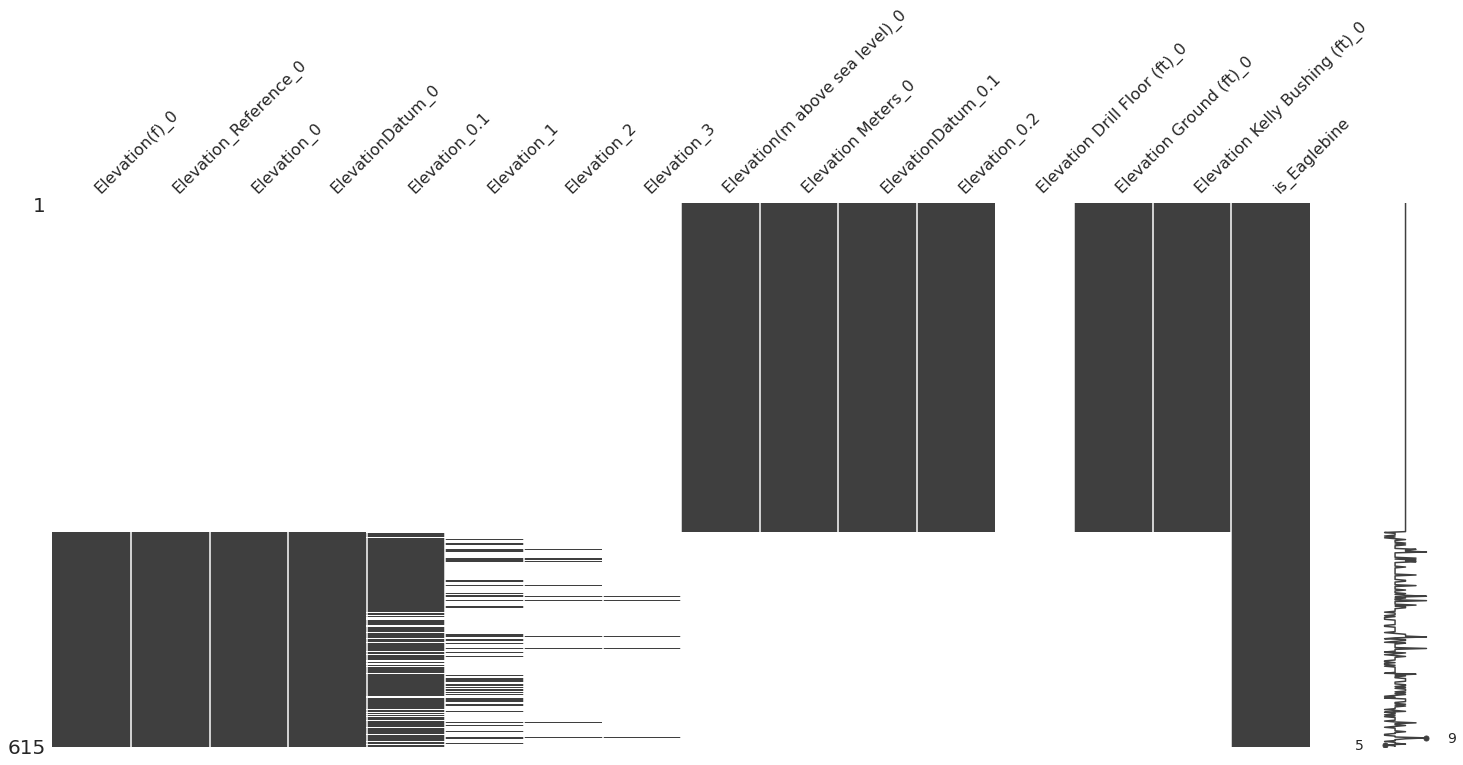

In [20]:
elev_cols = [col for col in train_df.columns if 'Elev' in col]
train_df['is_Eaglebine'] = pd.get_dummies(train_df['Basin'], drop_first=True)

msno.matrix(train_df[elev_cols+['is_Eaglebine']])

In [21]:
train_df['ElevationDatum_0'].unique(), train_df['ElevationDatum_0.1'].unique() 

(array([nan, 'KB'], dtype=object), array(['KB', nan], dtype=object))

In [22]:
def merge_elevations(row):
  if type(row['ElevationDatum_0']) == float:
    if type(row['ElevationDatum_0.1']) == float:
      return ''
    else:
      return row['ElevationDatum_0.1']
  else:
    if type(row['ElevationDatum_0.1']) == float:
      return row['ElevationDatum_0']
    else:
      if row['ElevationDatum_0'] == row['ElevationDatum_0.1']:
        return row['ElevationDatum_0']
      else:
        return 'Pls check'

elev_serie = train_df[['ElevationDatum_0','ElevationDatum_0.1']].apply(merge_elevations, axis=1)
elev_serie.unique()

array(['KB'], dtype=object)

In [23]:
def df_preprocessing(train_df, ref_df=train_df):
  # Re joining LogData for DV wells, given a possible mistake on the UWI 
  # identifiers

  grs_1 = train_df.loc[:,'3600.0_GRWS':'24000.0_GRWS'].columns.to_list()
  grs_2 = train_df.loc[:,'300.0_GRWS':'3300.0_GRWS'].columns.to_list()
  grs_1.extend(grs_2)

  dv_index = train_df['UWI'][train_df['UWI'].str.contains('W')].values
  new_dv_index = pd.Series(dv_index).apply(lambda x: x[:-2])
  dv_df = pd.DataFrame(new_dv_index).rename({0:'UWI'},axis=1)

  new_dv_log = pd.merge(dv_df[['UWI']],
          logData_df,
          how='left',
          left_on='UWI',
          right_on='WellName').set_index('UWI')[grs_1]

  print('Wells without GR info before: ',train_df.loc[:,grs_1].mean(axis=1).isna().sum())

  train_df.loc[train_df['UWI'].isin(dv_index), grs_1] = new_dv_log[grs_1].values
  print('Wells without GR info after re join: ',train_df.loc[:,grs_1].mean(axis=1).isna().sum())

  train_df['GR_avg'] = train_df.loc[:,grs_1].mean(axis=1)

  # Turning the basin field into a single dummy column, for its inclusion
  # in the regression models

  train_df['is_Eaglebine'] = pd.get_dummies(train_df['Basin'], drop_first=True)

  #Merge the columns of interest into a single one

  train_df["TD (ft)"]=train_df["TD (ft)"].fillna(0)+train_df["Measured Depth (ft)_0.1"].fillna(0)
  train_df["Bottom Hole Location X_m_NAD27_Zone 11N (120 W to 114 W)_0"]=train_df["Bottom_Hole_Location_X_0"].fillna(0)+train_df["Bottom Hole Location X_m_NAD27_Zone 11N (120 W to 114 W)_0"].fillna(0)
  train_df["Bottom Hole Location Y_m_NAD27_Zone 11N (120 W to 114 W)_0"]=train_df["Bottom_Hole_Location_Y_0"].fillna(0)+train_df["Bottom Hole Location Y_m_NAD27_Zone 11N (120 W to 114 W)_0"].fillna(0)
  train_df["Elevation(m above sea level)_0"]=train_df["Elevation(f)_0"].fillna(0)+train_df["Elevation(m above sea level)_0"].fillna(0)
  train_df["SurfaceLatitude_NAD83_0"]=train_df["SurfaceLatitude_NAD83_0"].fillna(0)+train_df["SurfaceLatitude_NAD83_0.1"].fillna(0)
  train_df["SurfaceLongitude_NAD83_0"]=train_df["SurfaceLongitude_NAD83_0"].fillna(0)+train_df["SurfaceLongitude_NAD83_0.1"].fillna(0)
  train_df["BottomLatitude_NAD83_0"]=train_df["BottomLatitude_NAD83_0"].fillna(0)+train_df["BottomLatitude_NAD83_0.1"].fillna(0)
  train_df["BottomLongitude_NAD83_0"]=train_df["BottomLongitude_NAD83_0"].fillna(0)+train_df["BottomLongitude_NAD83_0.1"].fillna(0)
  train_df["SurfaceLatitude_NAD27_0"]=train_df["SurfaceLatitude_NAD27_0"].fillna(0)+train_df["SurfaceLatitude_NAD27_0.1"].fillna(0)
  train_df["SurfaceLongitude_NAD27_0"]=train_df["SurfaceLongitude_NAD27_0"].fillna(0)+train_df["SurfaceLongitude_NAD27_0.1"].fillna(0)
  train_df["BottomLatitude_NAD27_0"]=train_df["BottomLatitude_NAD27_0"].fillna(0)+train_df["BottomLatitude_NAD27_0.1"].fillna(0)
  train_df["BottomLongitude_NAD27_0"]=train_df["BottomLongitude_NAD27_0"].fillna(0)+train_df["BottomLongitude_NAD27_0.1"].fillna(0)
  train_df["Oil Total Cum (bbl)_0"]=train_df["Oil Total Cum (bbl)_0"].fillna(0)+train_df["Oil Total Cum (bbl)_0.1"].fillna(0)
  train_df["Gas Total Cum (mcf)_0"]=train_df["Gas Total Cum (mcf)_0"].fillna(0)+train_df["Gas Total Cum (mcf)_0.1"].fillna(0)
  train_df["Water Total Cum (bbl)_0"]=train_df["Water Total Cum (bbl)_0"].fillna(0)+train_df["Water Total Cum (bbl)_0.1"].fillna(0)
  train_df["GOR Total Average_0"]=train_df["GOR Total Average_0"].fillna(0)+train_df["GOR Total Average_0.1"].fillna(0)
  train_df["Gas Maximum (mcf)_0"]=train_df["Gas Maximum (mcf)_0"].fillna(0)+train_df["Gas Maximum (mcf)_0.1"].fillna(0)
  train_df["Oil Maximum (bbl)_0"]=train_df["Oil Maximum (bbl)_0"].fillna(0)+train_df["Oil Maximum (bbl)_0.1"].fillna(0)
  train_df["Water Maximum (bbl)_0"]=train_df["Water Maximum (bbl)_0"].fillna(0)+train_df["Water Maximum (bbl)_0.1"].fillna(0)
  train_df["Elevation Meters_0"]=train_df["Elevation Meters_0"].fillna(0)+train_df["Elevation_0"].fillna(0)
  train_df["ElevationDatum_0.1"]=train_df["ElevationDatum_0.1"]+train_df["ElevationDatum_0"]

  #Drop of merged columns

  to_drop_1_set={"Measured Depth (ft)_0.1","Bottom_Hole_Location_X_0","Bottom_Hole_Location_Y_0",
            "Elevation(f)_0","SurfaceLatitude_NAD83_0.1","SurfaceLongitude_NAD83_0.1",
            "BottomLatitude_NAD83_0.1","BottomLongitude_NAD83_0.1","SurfaceLatitude_NAD27_0.1",
            "SurfaceLongitude_NAD27_0.1","BottomLatitude_NAD27_0.1","BottomLongitude_NAD27_0.1",
            "Oil Total Cum (bbl)_0.1","Gas Total Cum (mcf)_0.1","Water Total Cum (bbl)_0.1",
            "GOR Total Average_0.1","Gas Maximum (mcf)_0.1","Oil Maximum (bbl)_0.1","Water Maximum (bbl)_0.1",
            "Elevation_0","ElevationDatum_0" }

  # Creating the list of columns that we'll drop
  columns_to_drop = ['UWI','Basin', 'Field','Set','Unnamed: 0_x',
                    'Unnamed: 0_y','Unnamed: 1']
  columns_to_drop.extend(grs_1)

  # Adding the columns that are completely empty to the drop list
  nulls_serie = train_df.isna().sum()
  nulls_to_drop = nulls_serie[nulls_serie == train_df.shape[0]].index.to_list()
  columns_to_drop.extend(nulls_to_drop)

  # Total Depth columns 
  TDs_list = ['TD_{}'.format(i) for i in range(13)]
  # TDs columns will be dropped too 
  columns_to_drop.extend(TDs_list)

  # Kelly bushing height columns provide barely the value, we'll keep only the avg
  KBs_list = ['KB_{}'.format(i) for i in range(13)]
  train_df['KB'] = train_df[KBs_list].mean(axis=1)
  columns_to_drop.extend(KBs_list)

  # About Mud Weights and their reference measure depths, we decided
  # just to keep the first lecture and its depth Mud Wt_0 and MW@Depth(KB)_0
  MudWts_list = ['Mud Wt_{}'.format(i) for i in range(1,13)]
  MudWts_depth_list = ['MW@Depth(KB)_{}'.format(i) for i in range(1,13)]

  columns_to_drop.extend(MudWts_list)
  columns_to_drop.extend(MudWts_depth_list)

  # Columns that represent the same KB elevation value we already have, 
  # and then, we will drop 
  kb_repeated = ['Elevation_Reference_0', 'Elevation(f)_0'] 
  columns_to_drop.extend(kb_repeated) 

  # Bottom_Hole_Location_X_0 - Bottom_Hole_Location_Y_0 and X(f)_0 - Y(f)_0 Pairs
  # represent the same values, we'll keep the columns with the representative
  # name
  bottm_hole_loc_drop = ['X(f)_0', 'Y(f)_0'] 
  columns_to_drop.extend(bottm_hole_loc_drop)  

  # Reducing well georeferencing columns to the most significant ones
  # We keep NAD83 and NAD27 references

  georef_dropable = ['WGS84Latitude_0', 'WGS84Longitude_0',
                    'SurfLat_0', 'SurfLong_0', 'Latitude_0','Longitude_0']
  columns_to_drop.extend(georef_dropable)

  # We drop Measured Depth (ft)_0/1/2/3 given they represent the same TD we
  # already have
  md_dropable = ['Measured Depth (ft)_{}'.format(i) for i in range(4)]
  columns_to_drop.extend(md_dropable)

  # We delete these columns that share the same values as TD's columns
  tvd_dropable = ['Total Vertical Depth (ft)_{}'.format(i) for i in range(4)]
  columns_to_drop.extend(tvd_dropable) 

  # We remove all Date related columns that are not useful for our regression
  # purposes
  date_cols = [col for col in train_df.columns if ('Date' in col or 'Month' in col)]
  columns_to_drop.extend(date_cols) 

  # We remove Elevation_1/2/3 
  elevations_dropable = ['Elevation_{}'.format(i) for i in range(1,4)] 
  columns_to_drop.extend(elevations_dropable) 

  # Merging Oil Total Cum columns into a single one 
  oil_tot_cum = ['Oil Total Cum (bbl)_{}'.format(i) for i in range(4)] 
  train_df['Oil Total Cum (bbl)_avg'] = train_df[oil_tot_cum].mean(axis=1)
  columns_to_drop.extend(oil_tot_cum) 

  # Merging Gas Total Cum columns into a single one 
  gas_tot_cum = ['Gas Total Cum (mcf)_{}'.format(i) for i in range(4)] 
  train_df['Gas Total Cum (mcf)_avg'] = train_df[gas_tot_cum].mean(axis=1)
  columns_to_drop.extend(gas_tot_cum) 

  # Merging Water Total Cum columns into a single one 
  water_tot_cum = ['Water Total Cum (bbl)_{}'.format(i) for i in range(4)] 
  train_df['Water Total Cum (bbl)_avg'] = train_df[water_tot_cum].mean(axis=1)
  columns_to_drop.extend(water_tot_cum) 

  # Merging GOR Total Average columns into a single one 
  GOR_tot_cum = ['GOR Total Average_{}'.format(i) for i in range(4)] 
  train_df['GOR Total Average_avg'] = train_df[GOR_tot_cum].mean(axis=1)
  columns_to_drop.extend(GOR_tot_cum) 

  # Merging Gas Maximum columns into a single one 
  gas_max = ['Gas Maximum (mcf)_{}'.format(i) for i in range(4)] 
  train_df['Gas Maximum (mcf)_avg'] = train_df[gas_max].mean(axis=1)
  columns_to_drop.extend(gas_max) 

  # Merging Oil Maximum columns into a single one 
  oil_max = ['Oil Maximum (bbl)_{}'.format(i) for i in range(4)] 
  train_df['Oil Maximum (bbl)_avg'] = train_df[oil_max].mean(axis=1)
  columns_to_drop.extend(oil_max) 

  # Merging Water Maximum columns into a single one 
  water_max = ['Water Maximum (bbl)_{}'.format(i) for i in range(4)] 
  train_df['Water Maximum (bbl)_avg'] = train_df[water_max].mean(axis=1)
  columns_to_drop.extend(water_max) 

  # Merging Liquid Injection Cum columns into a single one 
  liquid_inj_cum = ['Liquid Injection Cum (bbl)_{}'.format(i) for i in range(4)] 
  train_df['Liquid Injection Cum (bbl)_avg'] = train_df[liquid_inj_cum].mean(axis=1)
  columns_to_drop.extend(liquid_inj_cum) 

  # Merging Gas Injection Cum columns into a single one 
  gas_inj_cum = ['Gas Injection Cum (mcf)_{}'.format(i) for i in range(4)] 
  train_df['Gas Injection Cum (mcf)_avg'] = train_df[gas_inj_cum].mean(axis=1)
  columns_to_drop.extend(gas_inj_cum) 

  ########################################################

  # Dropping columns that are already in other ones
  repeated_cols = ['Elevation_0.2','Elevation Kelly Bushing (ft)_0',
                  'Total_Depth(f)_0','TD meters_0','Total Vertical Depth (ft)_0.1',
                  'Depth_SS(m)','Liquid Injection Cum (bbl)_avg',
                  'Gas Injection Cum (mcf)_avg','WellName','LogType','KB',
                  'Mud Wt_0','MW@Depth(KB)_0']

  columns_to_drop.extend(repeated_cols) 
  train_df.drop(columns_to_drop, axis=1, inplace=True)

  cols_set = set(train_df.columns)
  remaining_drops = cols_set.intersection(to_drop_1_set)

  if remaining_drops:
    train_df.drop(list(remaining_drops), axis=1, inplace=True)

  # Creating a list containing all the formations names
  fm_1 = train_df.loc[:,'01_Wilcox_MD_ft_0':'19_Cotton_Valley_MD_ft_0'].columns.to_list()
  fm_2 = train_df.loc[:,'01_Battle (Surbiton)[SSTVD] (m)_0':'17_Precambrian Basement (Surbiton)[SSTVD] (m)_0'].columns.to_list()

  fm_1.extend(fm_2) 
  fm_1.extend(['td_0','Elevation_0.1','Elevation Ground (ft)_0','Yield Total Average_0'])

  # Droping the formations tops, for both DV and EB
  train_df.drop(fm_1, axis=1, inplace=True)

  def impute_gr(row, ref_df=ref_df):
    if np.isnan(row['GR_avg']):
      fm_cond = ref_df['is_Eaglebine'] == row['is_Eaglebine']
      TD_cond = ref_df['TD (ft)'] >= row['TD (ft)'] - 500
      cond = fm_cond & TD_cond
      interest_df = ref_df.loc[cond]

      return interest_df['GR_avg'].mean()
    else:
      return row['GR_avg']

  train_df['GR_avg'] = train_df.apply(impute_gr, axis=1)

  return train_df

In [24]:
train_df = pd.read_csv(os.path.join(data_path,'training.csv'))
val_df = pd.read_csv(os.path.join(data_path,'val_data_no_label.csv'))
logData_df = pd.read_csv(os.path.join(data_path,'LogData.csv')).drop(['Unnamed: 0','Unnamed: 1'],axis=1)

final_train_df = df_preprocessing(train_df, ref_df=train_df)
final_val_df = df_preprocessing(val_df, ref_df=train_df)

Wells without GR info before:  504
Wells without GR info after re join:  134
Wells without GR info before:  168
Wells without GR info after re join:  41


In [25]:
display(train_df.shape)
display(train_df.head())

(615, 25)

,BHT,TrueTemp,TD (ft),Well_Id,SurfaceLatitude_NAD83_0,SurfaceLongitude_NAD83_0,BottomLatitude_NAD83_0,BottomLongitude_NAD83_0,SurfaceLatitude_NAD27_0,SurfaceLongitude_NAD27_0,BottomLatitude_NAD27_0,BottomLongitude_NAD27_0,Bottom Hole Location X_m_NAD27_Zone 11N (120 W to 114 W)_0,Bottom Hole Location Y_m_NAD27_Zone 11N (120 W to 114 W)_0,Elevation(m above sea level)_0,Elevation Meters_0,GR_avg,is_Eaglebine,Oil Total Cum (bbl)_avg,Gas Total Cum (mcf)_avg,Water Total Cum (bbl)_avg,GOR Total Average_avg,Gas Maximum (mcf)_avg,Oil Maximum (bbl)_avg,Water Maximum (bbl)_avg
0,48.33,60.97,9081.0,100010107020W500,55.027981,-116.903553,55.027981,-116.903553,55.027981,-116.903553,55.027981,-116.903553,506245.60,6097691.89,701.0,701.093481,60.354233,0,0.000,0.000,0.000,0.000,0.00,0.000,0.0
1,34.26,63.98,5725.0,100010608109W500,55.987511,-115.390554,55.987511,-115.390554,55.987511,-115.390554,55.987511,-115.390554,600487.16,6205637.53,645.6,645.600000,54.595340,0,3422.286,2722.761,390.597,795.597,1084.16,1639.125,351.6
2,29.00,39.07,4895.0,100011206021W400,54.167413,-113.002674,54.167402,-113.002616,54.167413,-113.002674,54.167402,-113.002616,760983.75,6009309.66,651.6,651.600000,58.055750,0,0.000,0.000,0.000,0.000,0.00,0.000,0.0
3,64.00,69.47,8891.0,100011506915W500,54.969037,-116.188158,54.969037,-116.188158,54.969037,-116.188158,54.969037,-116.188158,552047.78,6091428.82,873.1,873.100000,59.446371,0,0.000,0.000,0.000,0.000,0.00,0.000,0.0
4,68.00,75.23,9160.0,100011804403W500,52.787328,-114.415621,52.787328,-114.415621,52.787328,-114.415621,52.787328,-114.415621,674348.88,5851523.70,946.9,946.900000,71.769875,0,0.000,0.000,0.000,0.000,0.00,0.000,0.0


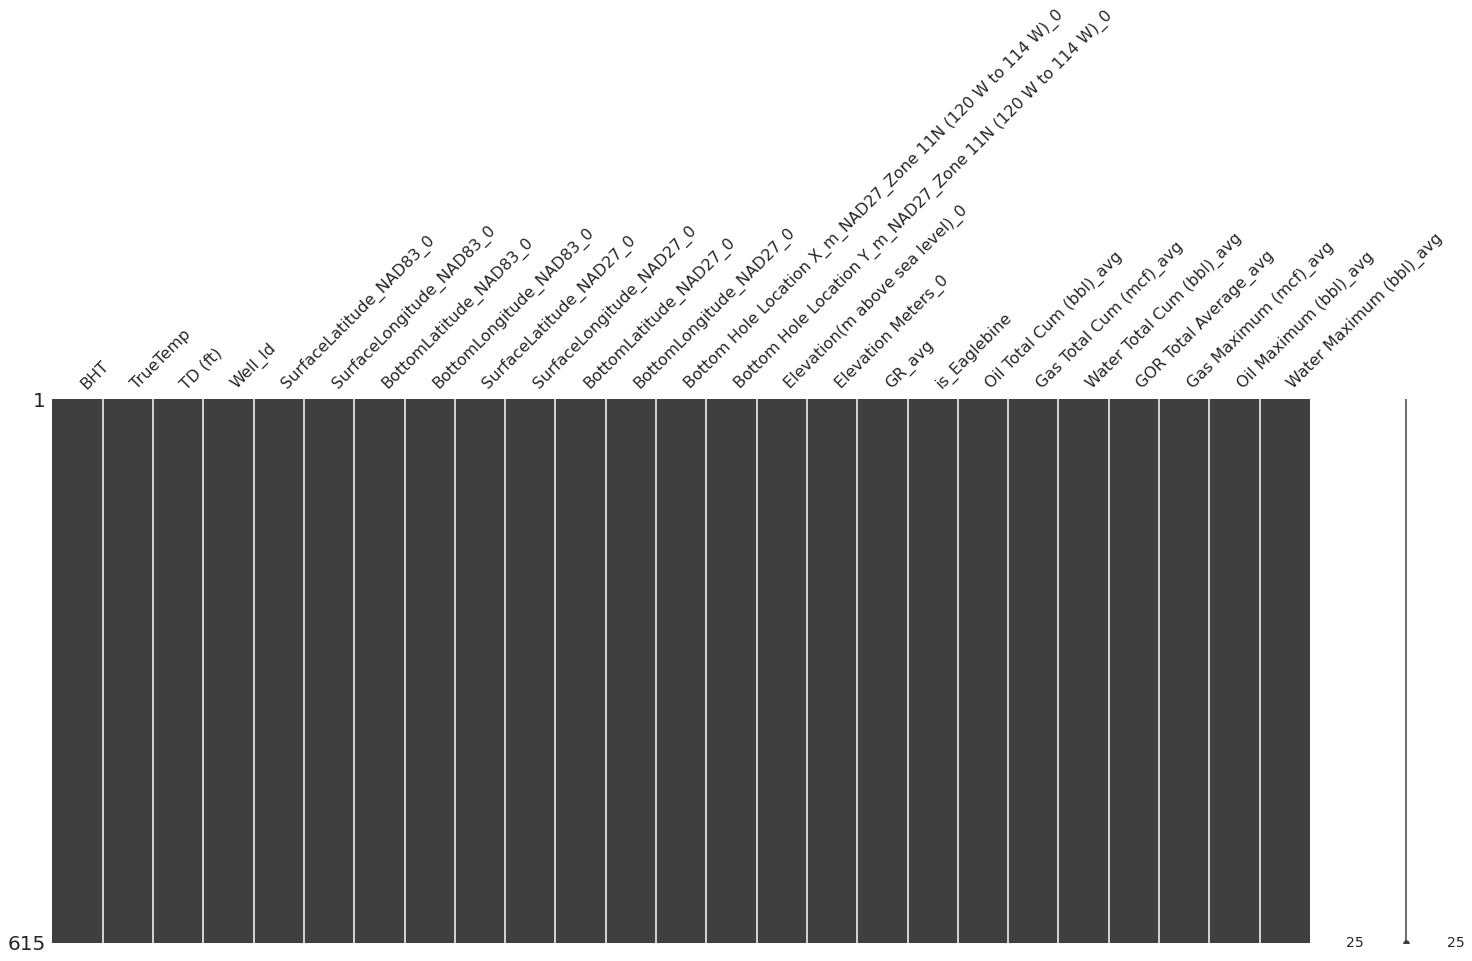

In [26]:
msno.matrix(train_df)

In [27]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 25 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   BHT                                                         615 non-null    float64
 1   TrueTemp                                                    615 non-null    float64
 2   TD (ft)                                                     615 non-null    float64
 3   Well_Id                                                     615 non-null    object 
 4   SurfaceLatitude_NAD83_0                                     615 non-null    float64
 5   SurfaceLongitude_NAD83_0                                    615 non-null    float64
 6   BottomLatitude_NAD83_0                                      615 non-null    float64
 7   BottomLongitude_NAD83_0                                     615 non-null    float64
 8   

In [28]:
from sklearn.preprocessing import StandardScaler # Standardizing Data

train_df_predictor = final_train_df.drop(['Well_Id', 'TrueTemp'], axis=1)
train_df_target = final_train_df[['TrueTemp']]


scaler_train_df_predictor = StandardScaler()
scaled_train_df_predictor = pd.DataFrame(scaler_train_df_predictor.fit_transform(train_df_predictor), columns=train_df_predictor.columns)
print (scaled_train_df_predictor.var())

BHT                                                           1.001629
TD (ft)                                                       1.001629
SurfaceLatitude_NAD83_0                                       1.001629
SurfaceLongitude_NAD83_0                                      1.001629
BottomLatitude_NAD83_0                                        1.001629
BottomLongitude_NAD83_0                                       1.001629
SurfaceLatitude_NAD27_0                                       1.001629
SurfaceLongitude_NAD27_0                                      1.001629
BottomLatitude_NAD27_0                                        1.001629
BottomLongitude_NAD27_0                                       1.001629
Bottom Hole Location X_m_NAD27_Zone 11N (120 W to 114 W)_0    1.001629
Bottom Hole Location Y_m_NAD27_Zone 11N (120 W to 114 W)_0    1.001629
Elevation(m above sea level)_0                                1.001629
Elevation Meters_0                                            1.001629
GR_avg

In [29]:
final_train_df_predictor = pd.concat([scaled_train_df_predictor, train_df_target], axis=1, sort=False)
print (final_train_df_predictor.head())

        BHT   TD (ft)  ...  Water Maximum (bbl)_avg  TrueTemp
0 -0.884813 -0.259612  ...                -0.211623     60.97
1 -1.364631 -1.561243  ...                -0.177381     63.98
2 -1.544008 -1.883160  ...                -0.211623     39.07
3 -0.350432 -0.333304  ...                -0.211623     69.47
4 -0.214023 -0.228971  ...                -0.211623     75.23

[5 rows x 24 columns]


# 3. Correlation
---

(0.0, 24.0)

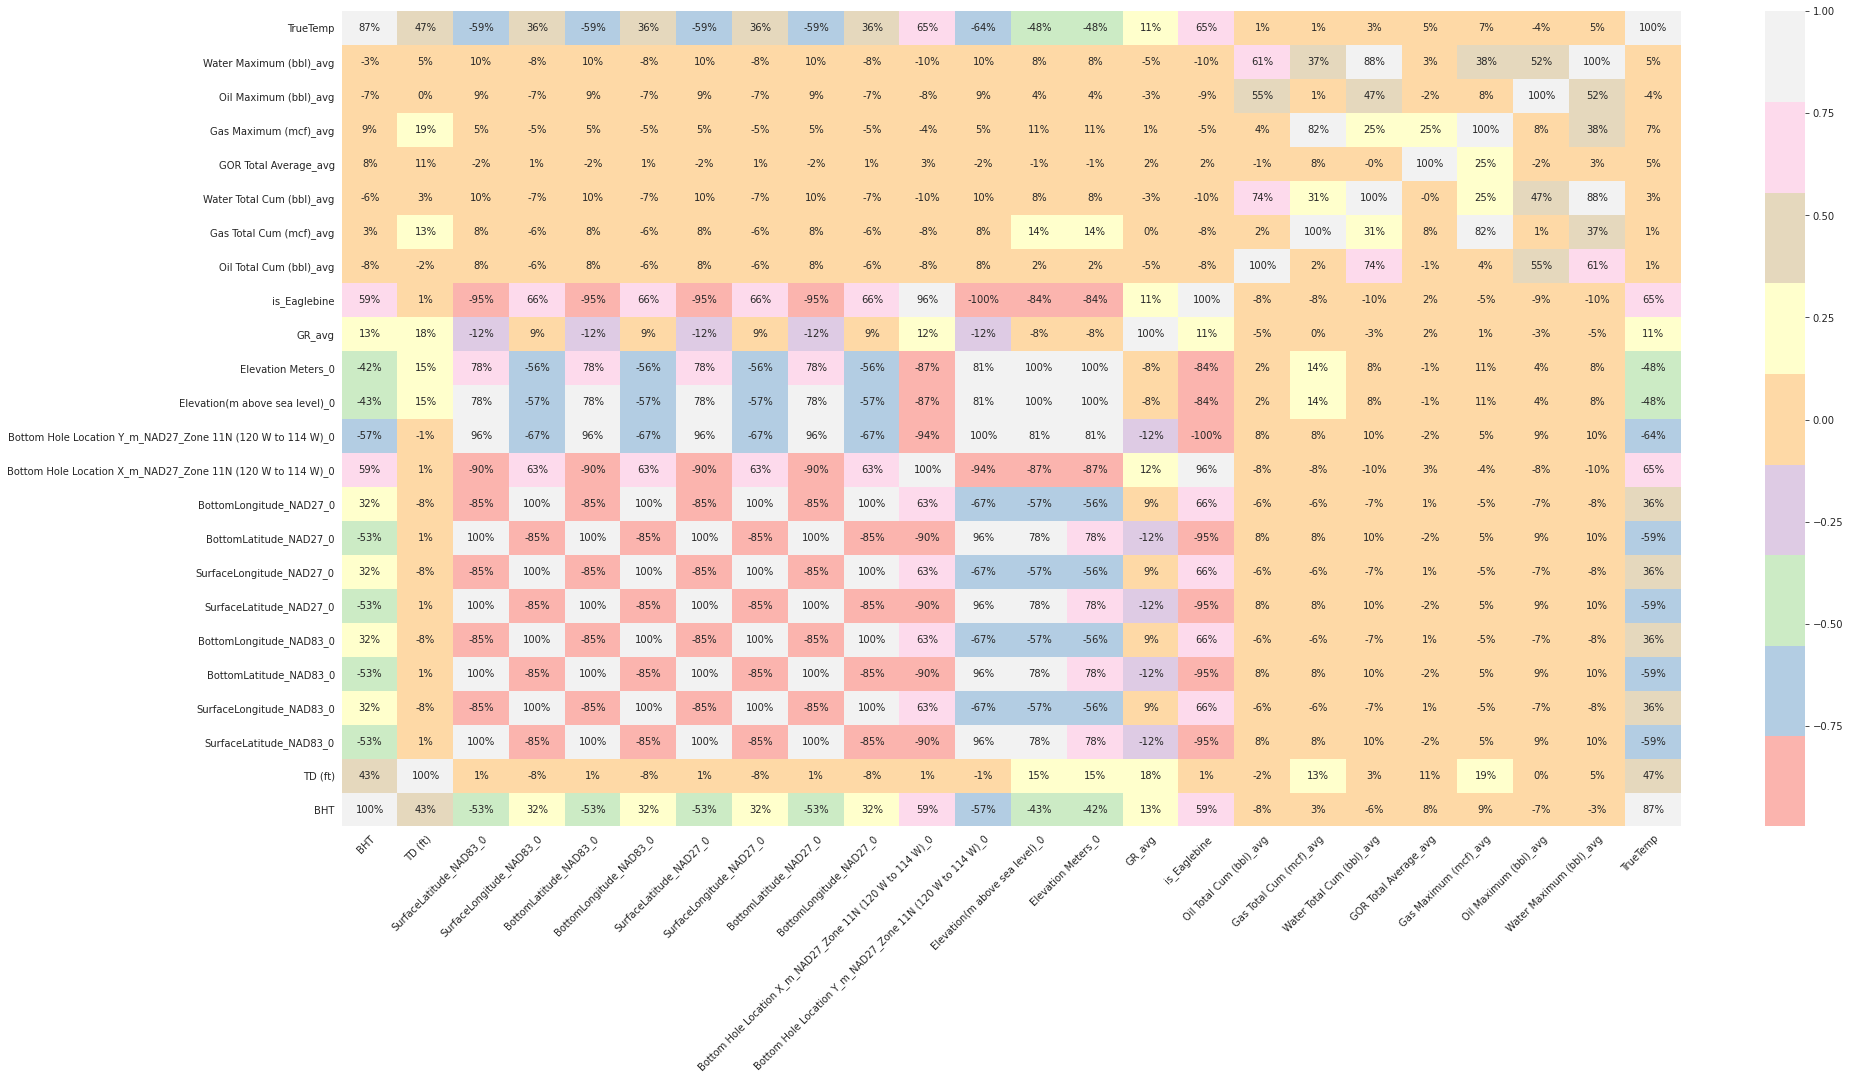

In [30]:
# Visualize correlation
%matplotlib inline
plt.figure(figsize=(30,15))

ax = sns.heatmap(final_train_df_predictor.corr(), annot=True, fmt ='.0%', cmap="Pastel1")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")
ax.set_ylim(len(final_train_df_predictor)-615,24) 

In [31]:
#Transform DataFrame to Numpy
scaled_train_np_predictor = scaled_train_df_predictor.to_numpy()
train_np_target = train_df_target.to_numpy()

In [32]:
type(scaled_train_np_predictor)

numpy.ndarray

In [33]:
scaled_train_np_predictor.shape

(615, 23)

In [34]:
train_np_target.shape

(615, 1)

# 4. Regression

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

In [36]:
X_train, X_test, y_train, y_test = train_test_split (scaled_train_np_predictor, train_np_target, test_size=0.2, 
                                                     random_state=1111)

### **Random Forest Regressor**

In [37]:
# GridSearch Random Forest
param_grid_rf = {'bootstrap': [True,False],
                  'max_depth': np.arange(1, 20, 2),
                  'min_samples_leaf': [3, 4, 5,6,7],
                  'n_estimators': [100,150, 200,250, 300, 1000]}

rf = RandomForestRegressor()


rf_training_GS = GridSearchCV(rf, param_grid_rf, cv=5)
rf_training_GS.fit(X_train, y_train)

print (rf_training_GS.best_params_)
print (rf_training_GS.best_score_)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using

{'bootstrap': True, 'max_depth': 13, 'min_samples_leaf': 3, 'n_estimators': 300}
0.8395439587813807


In [38]:
#Random Forest Regression

rf_training = RandomForestRegressor(bootstrap = True, max_depth = 11, min_samples_leaf = 3, n_estimators = 100)
rf_training.fit(X_train, y_train)

training_pred_rf = rf_training.predict(X_test)

score_rf = cross_val_score(rf_training,X_test, y_test,scoring='neg_mean_absolute_error', cv=5)
rf_scores = np.sqrt(-score_rf)
rf_scores

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_select

array([3.15473196, 2.97953864, 2.85192366, 3.5423592 , 3.30486983])

In [39]:
print("Mean of loss function random forest regression: ", np.round(np.mean(rf_scores),5))

Mean of loss function random forest regression:  3.16668


##**Decision Tree**

In [40]:
# GridSearch Decision Tree
param_grid_dt = {'max_depth': [2,3,4,5,6,7,8,10,15,20],
                 'min_samples_leaf': [1,2,3,4,5,6],'min_samples_split':[0,2,3,4,5,6]}

dt = DecisionTreeRegressor()

dt_training_GS = GridSearchCV(dt, param_grid_dt, cv=5)
dt_training_GS.fit(X_train, y_train)

print (dt_training_GS.best_params_)
print (dt_training_GS.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0


/usr/local/lib/python3.7/dis

{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 6}
0.7934080009109026


In [41]:
#Decision Tree

dt_training = DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 6,min_samples_split= 4)
dt_training.fit(X_train, y_train)

training_pred_dt = dt_training.predict(X_test)

score_dt = cross_val_score(dt_training,X_test, y_test,scoring='neg_mean_absolute_error', cv=5)
dt_scores = np.sqrt(-score_dt)
dt_scores

array([3.52478049, 3.50783698, 3.20987362, 4.02177449, 3.58904027])

In [42]:
print("Mean of loss function decision tree regression: ", np.round(np.mean(dt_scores),5))

Mean of loss function decision tree regression:  3.57066


##**Gradient Boosting**

In [43]:
# GridSearch Gradient Boosting
import xgboost
param_grid_xgboost = {'n_estimators':[100,150,200,300,400,500], 
                      'learning_rate':[0.05, 0.10, 0.20, 0.3,0.5,0.8,1]}

xgboost_training_GS = GridSearchCV(xgboost.XGBRegressor(), param_grid_xgboost, cv=5)
xgboost_training_GS.fit(X_train, y_train)

print (xgboost_training_GS.best_params_)
print (xgboost_training_GS.best_score_)

[15:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [44]:
#XGBOOSTING

xgboost_training = xgboost.XGBRegressor(learning_rate= 0.05, n_estimators= 200,randome_state=42)
xgboost_training.fit(X_train, y_train)

training_pred_xgboost = xgboost_training.predict(X_test)

score_xgboost = cross_val_score(xgboost_training,X_test, y_test,scoring='neg_mean_absolute_error', cv=5)
xgboost_scores = np.sqrt(-score_xgboost)
xgboost_scores

[15:50:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([3.54747451, 2.93092507, 2.69629962, 3.17883676, 3.02140946])

In [45]:
print("Mean of loss function XGDBoosting: ", np.round(np.mean(xgboost_scores),5))

Mean of loss function XGDBoosting:  3.07499


##**Neural Network Attempt 1**

In [46]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense

In [47]:
import tensorflow as tf
from tensorflow import keras

def DNN (input_dim,neurons=50,loss="MeanAbsoluteError",activation="elu",Nout=1,L2_regularizer=False,
             metrics=['accuracy'],activation_out='sigmoid',init_mode=None,BatchOpt=False,dropout_rate=False):
    """ Function to run Deep Neural Network (5 hidden layer) for different hyperparameters"""
    np.random.seed(42)
    tf.random.set_seed(42)
    
    if(activation=='Leaky_relu'): activation = keras.layers.LeakyReLU(alpha=0.2)
    if(L2_regularizer): kernel_regularizer=keras.regularizers.l2() 
    else: kernel_regularizer=None
        
    # create model
    model = keras.models.Sequential()
    
    # Input & Hidden Layer 1
    model.add(keras.layers.Dense(neurons,input_dim=input_dim, activation=activation, 
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))
        
    # Hidden Layer 2
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))
        
    # Hidden Layer 3    
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))                                 
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))      
        
    # Output Layer 
    model.add(keras.layers.Dense(Nout,activation=activation_out)) 
        
    # Compile model
    model.compile(optimizer='adam',loss=loss,metrics=metrics)
             
    return model

In [48]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [49]:
np.random.seed(42)

param_grid = {'init_mode' : [None,'he_normal', 'he_uniform'],'neurons' : [50,100,200,500],
              'L2_regularizer':[True,False],'dropout_rate' : [False, 0.3, 0.4],'activation': ['relu','elu', 'Leaky_relu']}

# Run Keras KerasRegressor
model = KerasRegressor(build_fn=DNN, input_dim=X_train.shape[1],metrics=None,
                        activation_out=None,loss='mse')

grid = RandomizedSearchCV(model,param_grid,n_iter=50,scoring='neg_mean_squared_error', cv=3)

grid_resultR = grid.fit(X_train,y_train,batch_size=32,validation_data=(X_test,y_test),verbose=0,epochs=200)

In [50]:
grid_resultR.best_params_

{'L2_regularizer': False,
 'activation': 'elu',
 'dropout_rate': 0.3,
 'init_mode': None,
 'neurons': 500}

In [51]:
model_DNN = DNN (input_dim=X_train.shape[1],neurons=500,Nout=1,L2_regularizer= False,
        init_mode= None, dropout_rate= 0.3,activation= 'elu',metrics=None,
                        activation_out=None,loss='mae')
np.random.seed(42)
history_DNN = model_DNN.fit(X_train,y_train,validation_data=
                       (X_test,y_test),callbacks=False,verbose=1,epochs=100)

Epoch 1/100
16/16 [==============================] - 1s 18ms/step - loss: 83.8438 - val_loss: 54.8344
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 33.7004 - val_loss: 23.1271
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 21.8704 - val_loss: 13.8702
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 16.8671 - val_loss: 12.9511
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 14.0094 - val_loss: 10.9600
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 12.6213 - val_loss: 9.2466
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 11.3849 - val_loss: 9.3211
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 11.3707 - val_loss: 9.1880
Epoch 9/100
16/16 [==============================] - 0s 12ms/step - loss: 11.3061 - val_loss: 9.1065
Epoch 10/100
16/16 [==============================] - 0s 11ms/step - loss: 11.0859 - v

In [52]:
TrueTemp_pred_ANN = model_DNN.predict(X_test)
print(TrueTemp_pred_ANN.shape)
print(y_test.shape)

(123, 1)
(123, 1)


In [53]:
mae_W= mean_absolute_error(TrueTemp_pred_ANN, y_test)
print('mae of all training: ',mae_W)

mae of all training:  7.835862848558874


# 5. Performance of regressors

In [54]:
performance_reg = ['Random Forest Regression: ', 'Decision Trees Regression: ', 'XGDBoosting: ','Neural Network:']

performance_reg_acc =[np.mean(rf_scores),np.mean(dt_scores),np.mean(xgboost_scores),mae_W]

for i,clfier in enumerate(performance_reg_acc):
 print(performance_reg[i], np.round(performance_reg_acc[i],3))

Random Forest Regression:  3.167
Decision Trees Regression:  3.571
XGDBoosting:  3.075
Neural Network: 7.836


In [55]:
import matplotlib.patheffects as pe

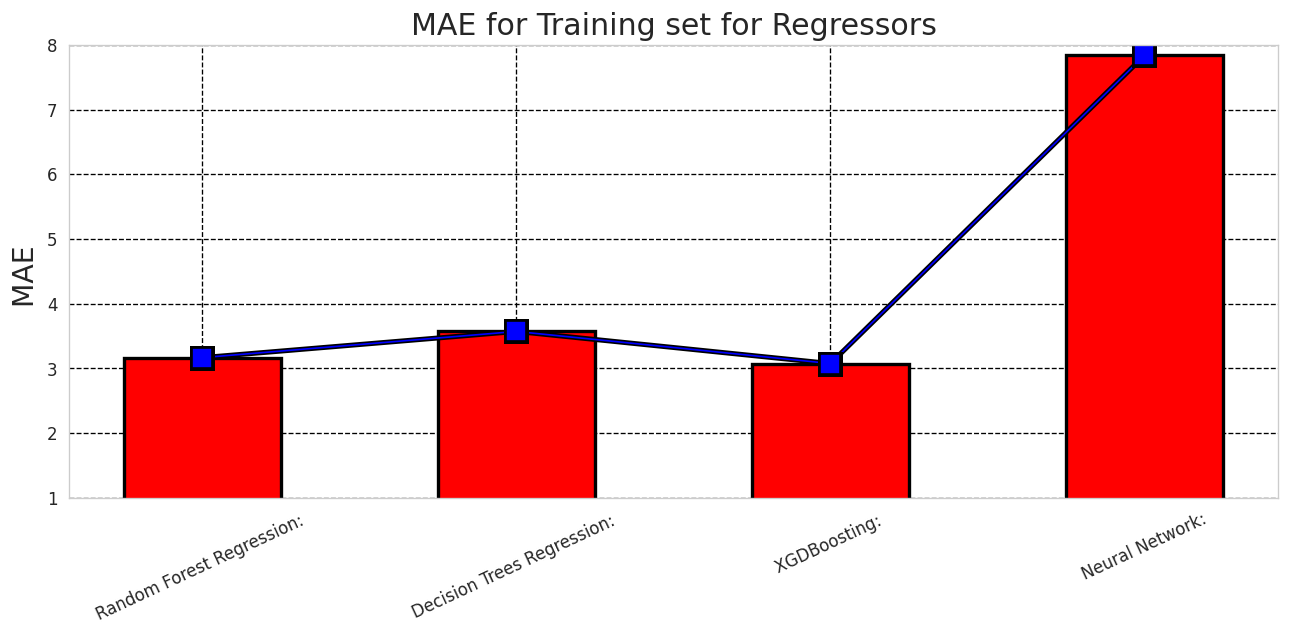

In [56]:
font = {'size'   :13}

fig, ax1 = plt.subplots(figsize=(13, 5), dpi= 120, facecolor='w', edgecolor='k')

plt.plot(performance_reg,performance_reg_acc,'bs-',linewidth=1,path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()],
                                                             markersize=12,label='Accuracy',markeredgecolor='k')
ax1.bar(performance_reg,performance_reg_acc,lw =2, align='center',width=0.5, alpha=1, ecolor='black', edgecolor='k',capsize=1,color='r')
plt.ylim((1, 8)) 
ax1.set_xticklabels(performance_reg, rotation=25)     
ax1.xaxis.grid(color='k', linestyle='--', linewidth=0.8) 
ax1.yaxis.grid(color='k', linestyle='--', linewidth=0.8)
plt.ylabel('MAE ',fontsize='17')
plt.title('MAE for Training set for Regressors',fontsize='18')
plt.show()

# 6. Validation

In [57]:
#Import validation dataset and run models. Compare scores (training and validation). 

In [58]:
final_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 24 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   BHT                                                         206 non-null    float64
 1   TD (ft)                                                     206 non-null    float64
 2   Well_Id                                                     206 non-null    object 
 3   SurfaceLatitude_NAD83_0                                     206 non-null    float64
 4   SurfaceLongitude_NAD83_0                                    206 non-null    float64
 5   BottomLatitude_NAD83_0                                      206 non-null    float64
 6   BottomLongitude_NAD83_0                                     206 non-null    float64
 7   SurfaceLatitude_NAD27_0                                     206 non-null    float64
 8   

In [64]:
final_val_df_predictor = final_val_df.drop(['Well_Id'], axis=1)


scaler_final_val_df_predictor = StandardScaler()
scaled_final_val_df_predictor = pd.DataFrame(scaler_final_val_df_predictor.fit_transform(final_val_df_predictor), columns=final_val_df_predictor.columns)
print (scaled_final_val_df_predictor.var())

BHT                                                           1.004878
TD (ft)                                                       1.004878
SurfaceLatitude_NAD83_0                                       1.004878
SurfaceLongitude_NAD83_0                                      1.004878
BottomLatitude_NAD83_0                                        1.004878
BottomLongitude_NAD83_0                                       1.004878
SurfaceLatitude_NAD27_0                                       1.004878
SurfaceLongitude_NAD27_0                                      1.004878
BottomLatitude_NAD27_0                                        1.004878
BottomLongitude_NAD27_0                                       1.004878
Bottom Hole Location X_m_NAD27_Zone 11N (120 W to 114 W)_0    1.004878
Bottom Hole Location Y_m_NAD27_Zone 11N (120 W to 114 W)_0    1.004878
Elevation(m above sea level)_0                                1.004878
Elevation Meters_0                                            1.004878
GR_avg

In [65]:
type(scaled_final_val_df_predictor)

pandas.core.frame.DataFrame

In [66]:
#Transform DataFrame to Numpy
scaled_final_val_np_predictor = scaled_final_val_df_predictor.to_numpy()
type(scaled_final_val_np_predictor)

numpy.ndarray

In [68]:
TrueTemp_pred_xgboost = xgboost_training.predict(scaled_final_val_np_predictor)
TrueTemp_pred_xgboost.shape

(206,)

In [73]:
final_val_df['TrueTemp']=TrueTemp_pred_xgboost

In [74]:
final_val_df['UWI'] = final_val_df['Well_Id']

In [75]:
final_val_df[['UWI','TrueTemp']].to_csv('predictions.csv')

In [76]:
final_val_df[['UWI','TrueTemp']].head()

,UWI,TrueTemp
0,100012404516W502,115.573112
1,100012805703W500,41.423351
2,100020206419W500,93.642082
3,100020605904W500,90.311020
4,100020606216W500,91.904350


In [77]:
import zipfile
zipfile.ZipFile('predictions.zip', mode='w').write("predictions.csv")

# 7. Recommendations

We completed an analysis to determine the most suitable wells to be converted from oil & gas wells for geothermal production. To carry out this task, we performed data visualization using TIBCO Spotfire in order to have a clear idea of the overall information through maps and graphs. In addition, based on what we saw in one of the Bootcamps, the solution of the heat equation with respect to 'z' and the schematic Depth-Temperature plot for geothermal resources, there are relevant parameters that have to be considered such as depth of the wells, true temperature and the average of formation thickness. 

Finally, we applied unsupervised learning in order to partition the n observations in k clusters, which gave us a better understanding of the wells that we could select for the conversion. However, most of these wells did not have large water productivity, which can be a critical aspect of the geothermal project. These are the results of our analysis and the recommended wells to be converted.

**Duvernay Field:** The K-Means Clustering map shows 3 clusters, the green color represents cluster 1, the yellow color represents cluster 2 and blue-violet represents cluster 3. In this case, the left-hand side graph illustrates the average true temperature, total depth, and formation thickness. Cluster 1 meets the criteria of depths less than 4,000 meters and true temperature over 75-celsius degrees. A small portion of these wells in cluster 1 had water productivity, represented in blue circles, as can be seen in the left corner map.

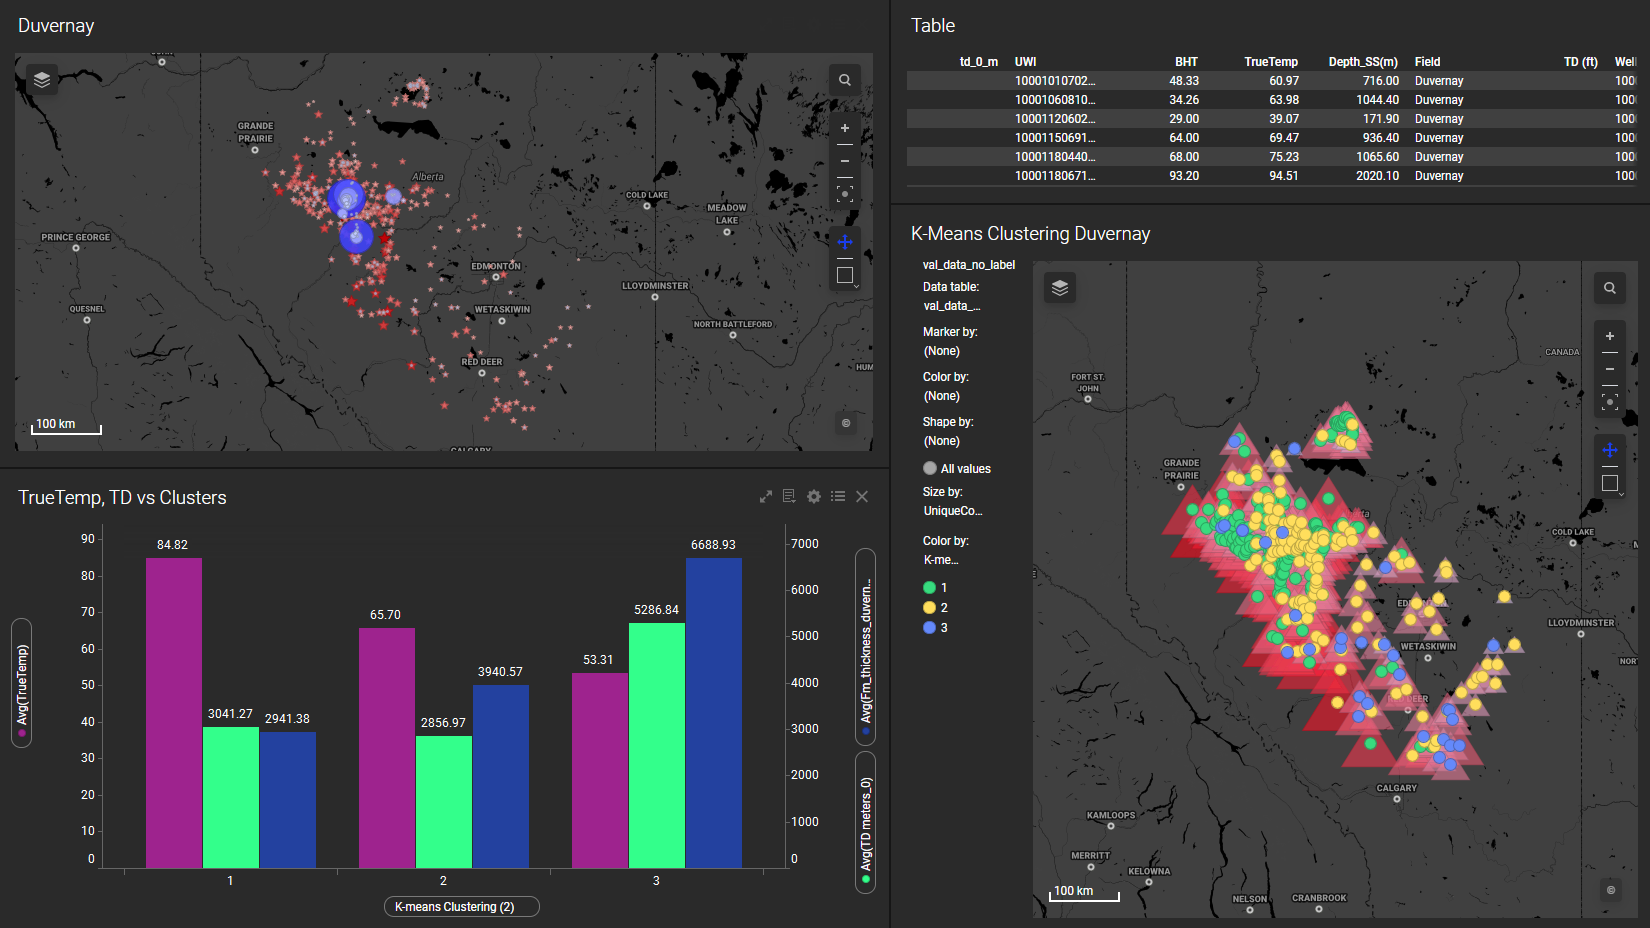

Wells to be converted for geothermal production in Duvernay Field:

*   100100205918W500
*   100103405818W500
*   100143206412W500
*   100022806419W500
*   100041106519W500
*   100021506419W500
*   100123506419W500
*   100071406220W500

**Validation dataset Duvernay**

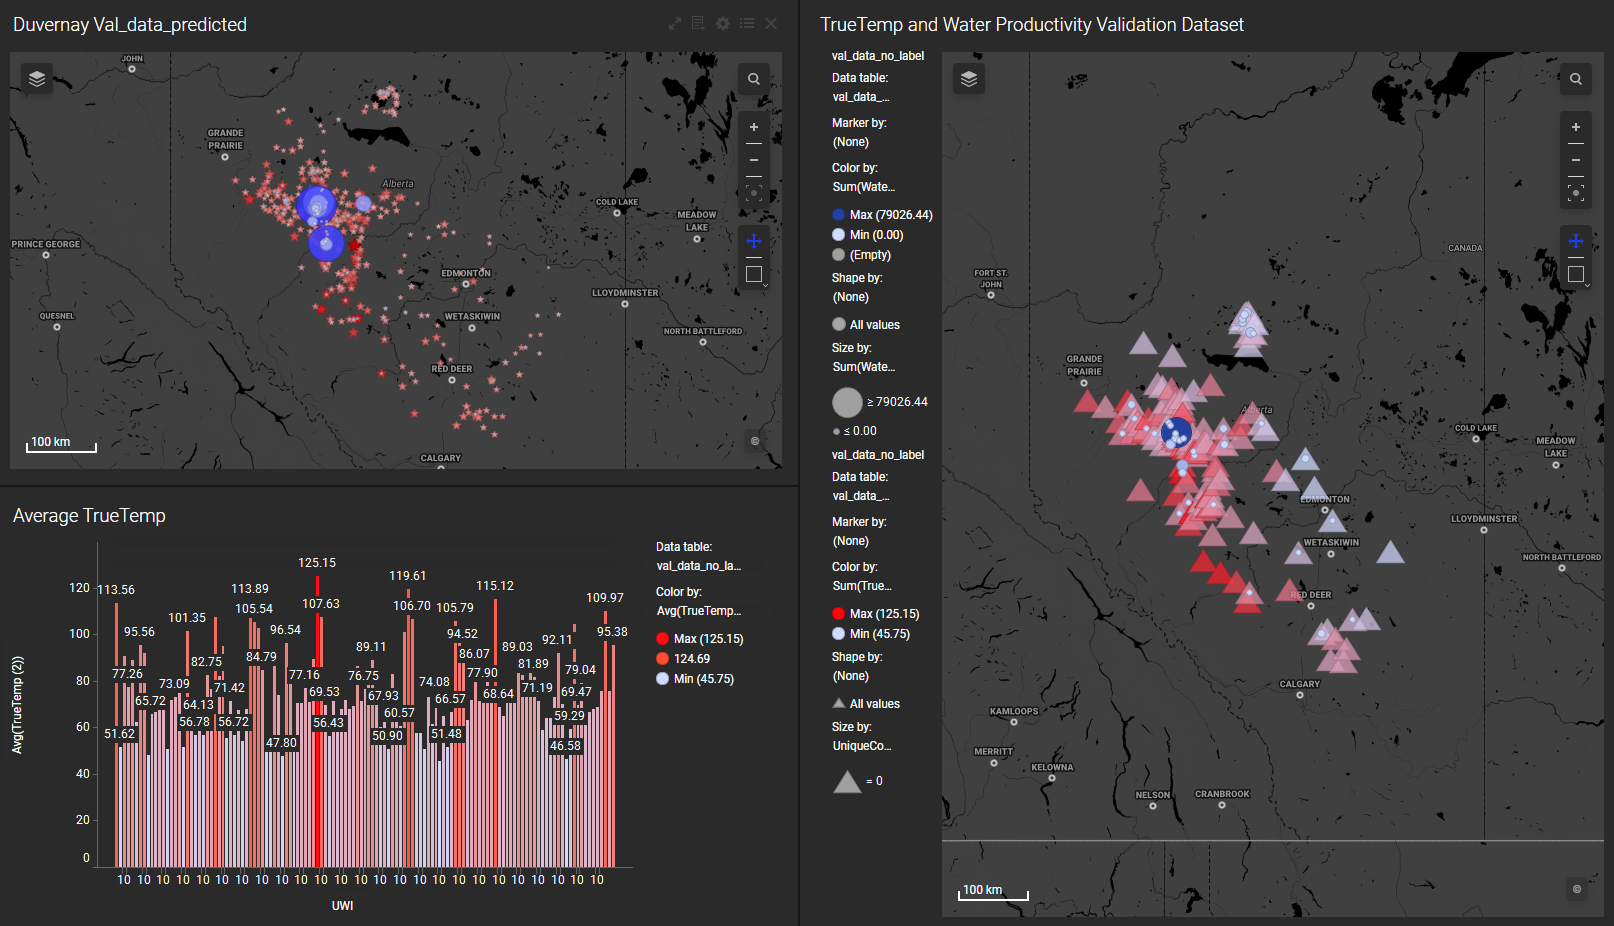

**Eaglebine Field:** The K-Means Clustering map shows 2 clusters, the blue color represents cluster 1, and the green color represents cluster 2. In this case, the left-hand side graph illustrates the average true temperature, and total depth. We did not consider formation thickness because the tops were reported in MD. Cluster 2 meets the criteria of depths less than 4,000 meters and true temperature over 75-celsius degrees. A small portion of these wells in cluster 2 had water productivity, represented in blue circles, as can be seen in the left corner map. Overall, the temperature in the Eaglebine field is considerably high.

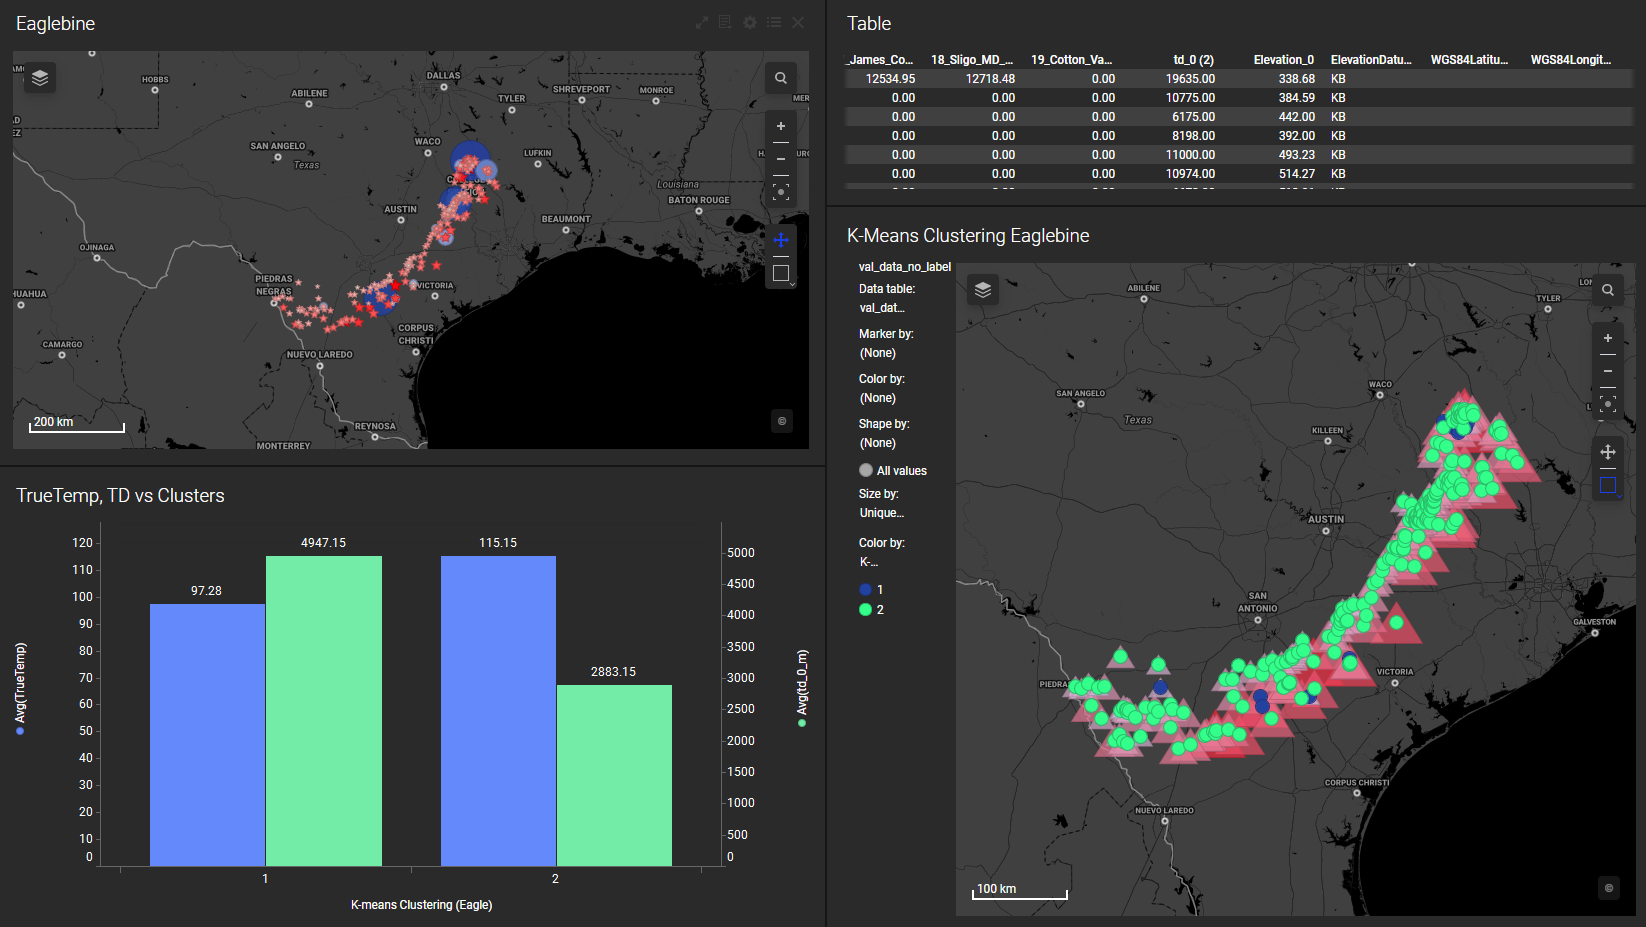

Wells to be converted for geothermal production in Eaglebine Field:

*   42013301930000
*   42289304700000
*   42051310530000
*   42051317780000
*   42289303540000
*   42041307950000 Validation dataset
*   42041307560000 Validation dataset

**Validation dataset Eaglebine**

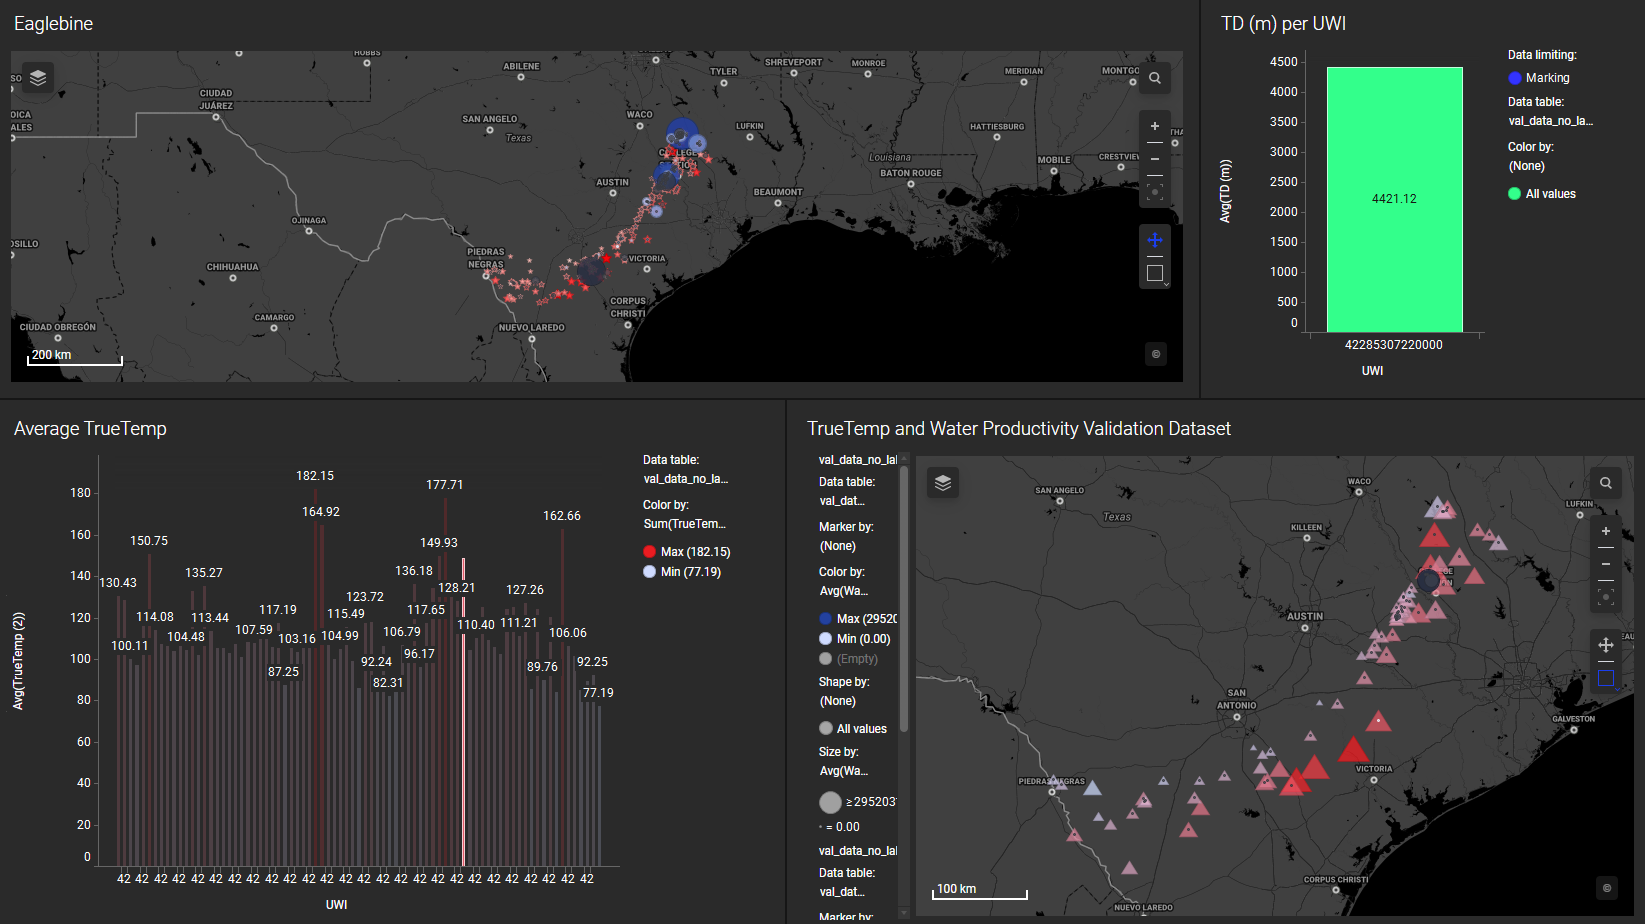